# Linear SVM - Email Spam Classifier


In this section, we'll build a linear SVM classifier to classify emails into spam and ham. The dataset, taken from the UCI ML repository, contains about 4600 emails labelled as **spam** or **ham**. 

The dataset can be downloaded here: https://archive.ics.uci.edu/ml/datasets/spambase

## Data Understanding

Let's first load the data and understand the attributes meanings, shape of the dataset etc.

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# load the data
email_rec = pd.read_csv("Spam.csv",  sep = ',' )
print(email_rec.head())

   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_;  char_freq_(  \
0             0.00            0.00  ...         0.00        0.000   
1 

As of now, the columns are named as integers. Let's manually name the columns appropriately (column names are available at the UCI website here: https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names)

In [13]:
# # renaming the columns
# email_rec.columns  = ["word_freq_make", "word_freq_address", "word_freq_all", "word_freq_3d", 
#                       "word_freq_our", "word_freq_over", "word_freq_remove", "word_freq_internet", 
#                       "word_freq_order", "word_freq_mail", "word_freq_receive", "word_freq_will", 
#                       "word_freq_people", "word_freq_report", "word_freq_addresses", "word_freq_free", 
#                       "word_freq_business", "word_freq_email", "word_freq_you", "word_freq_credit", 
#                       "word_freq_your", "word_freq_font", "word_freq_000", "word_freq_money", "word_freq_hp", 
#                       "word_freq_hpl", "word_freq_george", "word_freq_650", "word_freq_lab", "word_freq_labs", 
#                       "word_freq_telnet", "word_freq_857", "word_freq_data", "word_freq_415", "word_freq_85", 
#                       "word_freq_technology", "word_freq_1999", "word_freq_parts", "word_freq_pm", "word_freq_direct",
#                       "word_freq_cs", "word_freq_meeting", "word_freq_original", "word_freq_project", "word_freq_re", 
#                       "word_freq_edu", "word_freq_table", "word_freq_conference", "char_freq_;", "char_freq_(", 
#                       "char_freq_[", "char_freq_!", "char_freq_$", "char_freq_hash", "capital_run_length_average", 
#                       "capital_run_length_longest", "capital_run_length_total", "spam"]
# print(email_rec.head())

In [14]:
# look at dimensions of the df
print(email_rec.shape)

(4601, 58)


In [15]:
# ensure that data type are correct
email_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

In [16]:
# there are no missing values in the dataset 
email_rec.isnull().sum()

word_freq_make                0
word_freq_address             0
word_freq_all                 0
word_freq_3d                  0
word_freq_our                 0
word_freq_over                0
word_freq_remove              0
word_freq_internet            0
word_freq_order               0
word_freq_mail                0
word_freq_receive             0
word_freq_will                0
word_freq_people              0
word_freq_report              0
word_freq_addresses           0
word_freq_free                0
word_freq_business            0
word_freq_email               0
word_freq_you                 0
word_freq_credit              0
word_freq_your                0
word_freq_font                0
word_freq_000                 0
word_freq_money               0
word_freq_hp                  0
word_freq_hpl                 0
word_freq_george              0
word_freq_650                 0
word_freq_lab                 0
word_freq_labs                0
word_freq_telnet              0
word_fre

Let's also look at the fraction of spam and ham emails in the dataset.

In [17]:
# look at fraction of spam emails 
# 39.4% spams
email_rec['spam'].describe()

count    4601.000000
mean        0.394045
std         0.488698
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: spam, dtype: float64

## Data Preparation

Let's now conduct some prelimininary data preparation steps, i.e. rescaling the variables, splitting into train and test etc. To understand why rescaling is required, let's print the summary stats of all columns - you'll notice that the columns at the end (capital_run_length_longest, capital_run_length_total etc.) have much higher values (means = 52, 283 etc.) than most other columns which represent fraction of word occurrences (no. of times word appears in email/total no. of words in email).

In [8]:
email_rec.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_hash,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


In [18]:
# splitting into X and y
X = email_rec.drop("spam", axis = 1)
y = email_rec.spam.values.astype(int)

In [19]:
# scaling the features
# note that the scale function standardises each column, i.e.
# x = x-mean(x)/std(x)

from sklearn.preprocessing import scale
X = scale(X)

In [20]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)

In [22]:
# confirm that splitting also has similar distribution of spam and ham 
# emails
print(y_train.mean())
print(y_test.mean())

0.3978260869565217
0.38522809558291093


## Model Building

Let's build a linear SVM mode now. The ```SVC()``` class does that in sklearn. We highly recommend reading the documentation at least once.

In [26]:
help(SVC)

Help on class SVC in module sklearn.svm._classes:

class SVC(sklearn.svm._base.BaseSVC)
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`sklearn.svm.LinearSVC` or
 |  :class:`sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  other, see the corresponding section in the narrative documentation:
 |  :ref:`svm_kernels`.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 |  C : float, default=1.0
 |      Regularization parame

In [28]:
# Model building

# instantiate an object of class SVC()
# note that we are using cost C=1
model = SVC(C = 1)

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

In [29]:
# Evaluate the model using confusion matrix 
from sklearn import metrics
metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[811,  38],
       [ 61, 471]])

In [30]:
# print other metrics

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

# precision
print("precision", metrics.precision_score(y_test, y_pred))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred))


accuracy 0.9283128167994207
precision 0.925343811394892
recall 0.8853383458646616


In [31]:
# specificity (% of hams correctly classified)
print("specificity", 811/(811+38))

specificity 0.9552414605418139


The SVM we have built so far gives decently good results - an accuracy of 92%, sensitivity/recall (TNR) of 88%. 

### Interpretation of Results

In the confusion matrix, the elements at (0, 0) and (1,1) correspond to the more frequently occurring class, i.e. ham emails. Thus, it implies that:
- 92% of all emails are classified correctly
- 88.5% of spams are identified correctly (sensitivity/recall)
- Specificity, or % of hams classified correctly, is 95%



## Hyperparameter Tuning

In [18]:
help(metrics.confusion_matrix)

Help on function confusion_matrix in module sklearn.metrics.classification:

confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)
    Compute confusion matrix to evaluate the accuracy of a classification
    
    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` but
    predicted to be in group :math:`j`.
    
    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
    
    Read more in the :ref:`User Guide <confusion_matrix>`.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (correct) target values.
    
    y_pred : array, shape = [n_samples]
        Estimated targets as returned by a classifier.
    
    labels : array, shape = [n_classes], optional
        List of labels to index the m

### K-Fold Cross Validation

Let's first run a simple k-fold cross validation to get a sense of the **average metrics** as computed over multiple *folds*. the easiest way to do cross-validation is to use the ```cross_val_score()``` function.

In [33]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# instantiating a model with cost=1
model = SVC(C = 1)

In [35]:
# computing the cross-validation scores 
# note that the argument cv takes the 'folds' object, and
# we have specified 'accuracy' as the metric

cv_results = cross_val_score(model, X_train, y_train, cv = folds, scoring = 'accuracy') 

In [36]:
# print 5 accuracies obtained from the 5 folds
print(cv_results)
print("mean accuracy = {}".format(cv_results.mean()))

[0.91770186 0.94099379 0.92080745 0.93012422 0.93944099]
mean accuracy = 0.9298136645962731


## Grid Search to Find Optimal Hyperparameter C

K-fold CV helps us compute average metrics over multiple folds, and that is the best indication of the 'test accuracy/other metric scores' we can have. 

But we want to use CV to compute the optimal values of hyperparameters (in this case, the cost C is a hyperparameter). This is done using the ```GridSearchCV()``` method, which computes metrics (such as accuracy, recall etc.) 

In this case, we have only one hyperparameter, though you can have multiple, such as C and gamma in non-linear SVMs. In that case, you need to search through a *grid* of multiple values of C and gamma to find the optimal combination, and hence the name GridSearchCV.

In [39]:
# specify range of parameters (C) as a list
params = {"C": [0.1, 1, 10, 100, 1000]}

model = SVC()

# set up grid search scheme
# note that we are still using the 5 fold CV scheme we set up earlier
model_cv = GridSearchCV(estimator = model, param_grid = params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                       return_train_score=True,n_jobs=-1)      

In [40]:
# fit the model - it will fit 5 folds across all values of C
model_cv.fit(X_train, y_train)  

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.2s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000]}, return_train_score=True,
             scoring='accuracy', verbose=1)

In [41]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.770300,0.091984,0.147925,0.032155,0.1,{'C': 0.1},0.895963,0.902174,0.906832,0.902174,...,0.905280,0.007795,5,0.912655,0.911879,0.912267,0.911102,0.906056,0.910792,0.002423
1,0.400336,0.013612,0.060853,0.005851,1,{'C': 1},0.917702,0.940994,0.920807,0.930124,...,0.929814,0.009440,2,0.951475,0.946040,0.949922,0.946040,0.945652,0.947826,0.002401
2,0.322136,0.024493,0.049428,0.003827,10,{'C': 10},0.908385,0.944099,0.933230,0.928571,...,0.930745,0.012368,1,0.975543,0.970885,0.973991,0.968944,0.971273,0.972127,0.002347
3,0.368018,0.019243,0.043317,0.004230,100,{'C': 100},0.913043,0.927019,0.936335,0.930124,...,0.928571,0.008562,3,0.989519,0.989907,0.989907,0.988354,0.987966,0.989130,0.000814
4,0.527026,0.046734,0.033207,0.003265,1000,{'C': 1000},0.908385,0.931677,0.922360,0.919255,...,0.920497,0.007440,4,0.996118,0.993789,0.994177,0.993789,0.994177,0.994410,0.000872


To get a better sense of how training and test accuracy varies with C, let's plot the tranining and test accuracies against C.

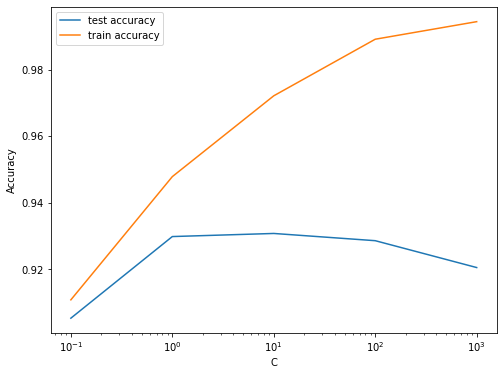

In [42]:
# plot of C versus train and test scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

Though the training accuracy monotonically increases with C, the test accuracy gradually reduces. Thus, we can conclude that higher values of C tend to **overfit** the model. This is because a high C value aims to classify all training examples correctly (since C is the *cost of misclassification* - if you impose a high cost on the model, it will avoid misclassifying any points by overfitting the data). 



Let's finally look at the optimal C values found by GridSearchCV.

In [43]:
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test accuracy is {0} at C = {1}".format(best_score, best_C))

 The highest test accuracy is 0.9307453416149067 at C = 10


Let's now look at the metrics corresponding to C=10.

In [44]:
# model with the best value of C
model = SVC(C=best_C)

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

In [45]:
# metrics
# print other metrics

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

# precision
print("precision", metrics.precision_score(y_test, y_pred))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred))


accuracy 0.9304851556842868
precision 0.9241245136186771
recall 0.8928571428571429


## Optimising for Other Evaluation Metrics

In this case, we had optimised (tuned) the model based on overall accuracy, though that may not always be the best metric to optimise. For example, if you are concerned more about catching all spams (positives), you may want to maximise TPR or sensitivity/recall. If, on the other hand, you want to avoid classifying hams as spams (so that any important mails don't get into the spam box), you would maximise the TNR or specificity.

In [29]:
# specify params
params = {"C": [0.1, 1, 10, 100, 1000]}

# specify scores/metrics in an iterable
scores = ['accuracy', 'precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for {}".format(score))
    
    # set up GridSearch for score metric
    clf = GridSearchCV(SVC(), 
                       params, 
                       cv=folds,
                       scoring=score,
                       return_train_score=True)
    # fit
    clf.fit(X_train, y_train)

    print(" The highest {0} score is {1} at C = {2}".format(score, clf.best_score_, clf.best_params_))
    print("\n")

# Tuning hyper-parameters for accuracy
 The highest accuracy score is 0.931055900621118 at C = {'C': 10}


# Tuning hyper-parameters for precision
 The highest precision score is 0.936509856470386 at C = {'C': 0.1}


# Tuning hyper-parameters for recall
 The highest recall score is 0.8994650196111064 at C = {'C': 10}




Thus, you can see that the optimal value of the hyperparameter varies significantly with the choice of evaluation metric.

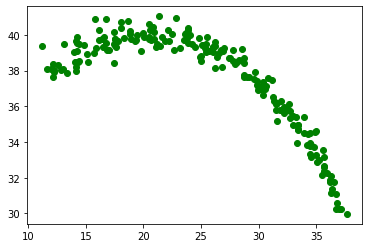

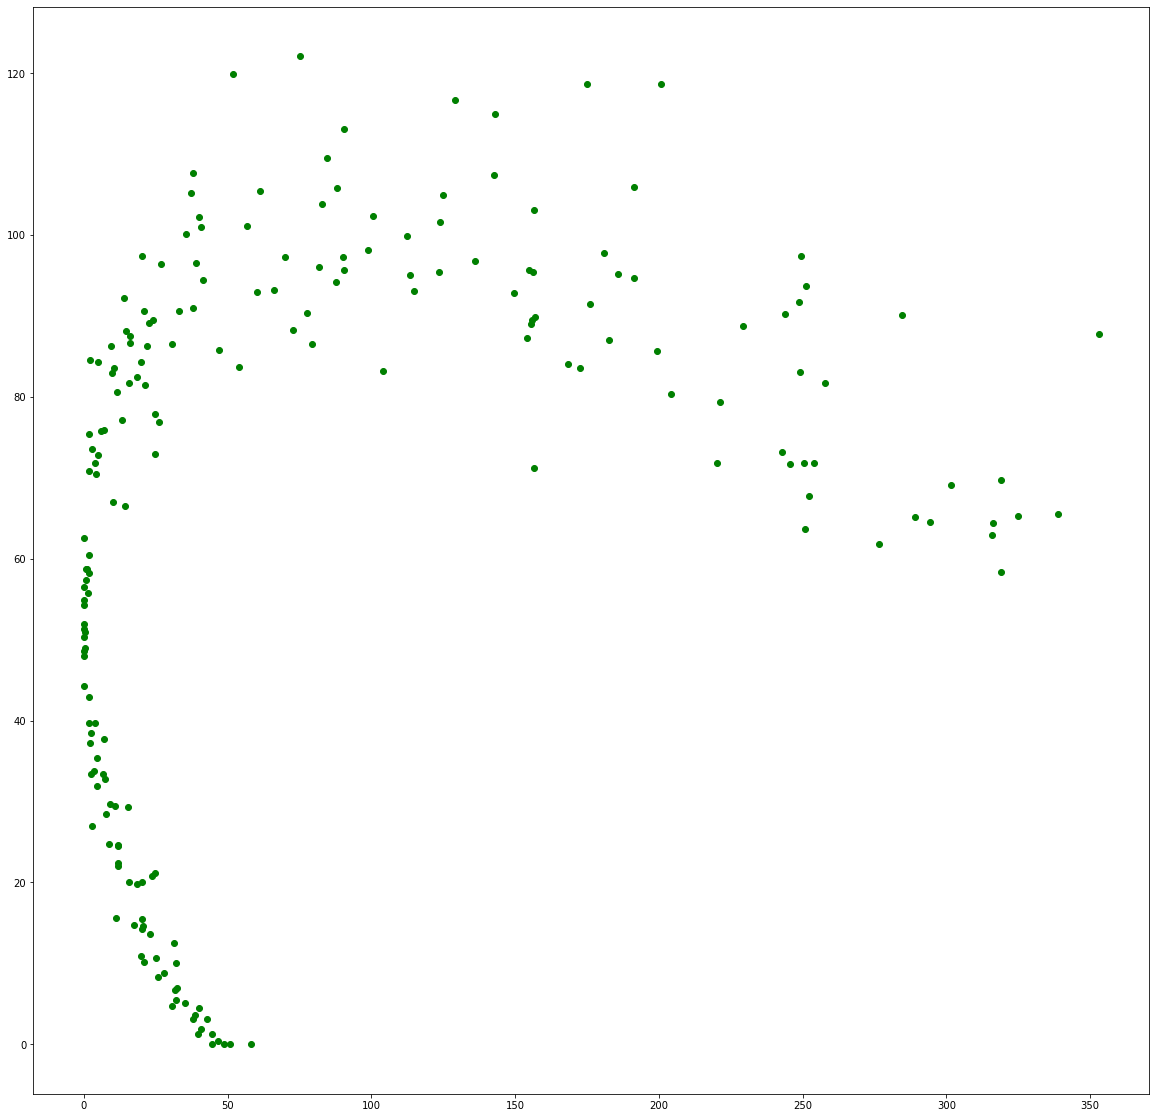

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
x=np.random.uniform(low=10, high=35, size=(200,)) + np.random.normal(loc=2, scale=0.5, size=200)
y = np.sqrt(400 - (x-20)**2)+ np.random.normal(loc=20, scale=0.5, size=200)
plt.scatter(x,y,color=['green'])
plt.figure(figsize=(20,20))
p = (x-30)**2
q = (y-30)**2
plt.scatter(p,q,color=['green'])